## Astro 330 "Computational Astrophysics"

### Homework 2. Integration of ODEs (60 points)

#### Distributed Wednesday, Oct 12; Due Wednesday, Oct 19, @6pm

In [2]:
from __future__ import division
from math import cos
import numpy as np
from time import time

from codes.plot_utils import plot_pretty
from matplotlib import pylab as plt
%matplotlib inline

<b>1. (30 points) <i>Implementing a Gragg-Bulirsch-Stoer integrator. Integrating a circular orbit in a fixed point mass potential.</i></b>

a. (20 points) Implement the Gragg-Bulirsch-Stoer (GBS) integration scheme, described in S 1.4.3 of my <a href="http://astro.uchicago.edu/~andrey/classes/a330f16/notes.pdf">notes</a>. Limit the order to $m=8$. Include the monitoring for step size similar to that implemented in the second part of routine <tt>rkf45</tt> in <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex03.ipynb">ex03.ipynb</a>. The logic of such step size monitoring is described in S 1.4.1 and 1.4.3 of my <a href="http://astro.uchicago.edu/~andrey/classes/a330f16/notes.pdf">notes</a>. 

Check results of your routine against my rkf45 routine  for a simple function in the r.h.s. coded up in <tt>func()</tt> in the ex03 notebook. If you want, you can check your routine against scipy's ODE integration routine <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html"><tt>odeint</tt></a>. Present results of your tests demonstrating correctness of your routine.

In [287]:
def func(t, r):
    return r*cos(t)

def n(k):
    return 2*(k+1)
    


def gbs_adaptive_general(f, r0, t_start, t_end, H, epsilon):
    
    t, r, H_init = t_start, r0, H; 
    tout = [t]; rout = [np.copy(r)]; steps=[H]
    
    e = epsilon
    Hmin = H/1e3
    Hmax = 1000*H
    
    while t < t_end: #Time loop over step H
            t_i = t
            r_i = r
            
            def G_lm(l,m):
                
                if m == 0:
        
                    h = H_init/(2*(l+1)) 
                    s_timesteps = np.arange(t_i,t_i+H_init,h)
                    
                    for s,ts in enumerate(s_timesteps):   #SUB-STEP s
                        
                        if s == 0:  #Step 1 : Calculate y(s=0) and y(s=1) using RK1
                            rs = r_i
                            rs_old = rs
                        if s == 1:
                            rs = r_i + 2*h*f(t_i,r_i)
                        else:
                            rs_new = rs_old + 2*h*f(ts,rs)
                            rs_old = rs
                            rs = rs_new
                    return rs
                       
                else:
                    term1 = (n(l)**2)*G_lm(l,m-1)
                    term2 =(n(l-m)**2)*G_lm(l-1,m-1)
                    return (term1 - term2)/((n(l)**2) - (n(l-m)**2))
        
        
            m = 8 #According to question
            r_m = G_lm(m+1,m)
            r_mplus1 = G_lm(m+1,m+1)
            
            #r = r_m
            #t += H_init
            #tout.append(t)
            #rout.append(r)
            #steps.append(H_init)
            
                      

            #Implementing Adaptive time step control    

            errorterm = np.abs(r_m[0] - r_mplus1[0]).max()
            
            #Fudge factor w is ignored
            delta = (e/errorterm)**(1/(2*m+2))
            
            if (errorterm < epsilon).any():
                r = r_m
                t = t + H_init
                if (delta>=1.0).any():
                    H_init = np.minimum(H_init*delta,Hmax)
                else:
                    H_init = np.minimum(H_init/deta,Hmax)
                tout.append(t)
                rout.append(r)
                steps.append(H_init)
        
            elif (errorterm >= epsilon).any():
                if (delta >= 1.0).any():
                    H_init /= delta
                else:
                    H_init *= delta    
                if (H_init < Hmin).any():
                    print H_init
                    raise Exception("step size H less than Hmin!")
            
            else:
                r = r_m
                t += H_init
                tout.append(t)
                rout.append(r)
                steps.append(H_init)
              
    return np.asarray(tout), np.asarray(rout), np.asarray(steps)



In [286]:
###### Runge-Kutta-Fehlberg 5th-4th order scheme that is combined to determine step size adaptively

# Coefficients used to compute the independent variable argument of f
c20  =   2.500000000000000e-01  #  1/4
c30  =   3.750000000000000e-01  #  3/8
c40  =   9.230769230769231e-01  #  12/13
c50  =   1.000000000000000e+00  #  1
c60  =   5.000000000000000e-01  #  1/2

# Coefficients used to compute the dependent variable argument of f
c21 =   2.500000000000000e-01  #  1/4
c31 =   9.375000000000000e-02  #  3/32
c32 =   2.812500000000000e-01  #  9/32
c41 =   8.793809740555303e-01  #  1932/2197
c42 =  -3.277196176604461e+00  # -7200/2197
c43 =   3.320892125625853e+00  #  7296/2197
c51 =   2.032407407407407e+00  #  439/216
c52 =  -8.000000000000000e+00  # -8
c53 =   7.173489278752436e+00  #  3680/513
c54 =  -2.058966861598441e-01  # -845/4104
c61 =  -2.962962962962963e-01  # -8/27
c62 =   2.000000000000000e+00  #  2
c63 =  -1.381676413255361e+00  # -3544/2565
c64 =   4.529727095516569e-01  #  1859/4104
c65 =  -2.750000000000000e-01  # -11/40

# Coefficients used to compute 4th order RK estimate
a1  =   1.157407407407407e-01  #  25/216
a2  =   0.000000000000000e-00  #  0
a3  =   5.489278752436647e-01  #  1408/2565
a4  =   5.353313840155945e-01  #  2197/4104
a5  =  -2.000000000000000e-01  # -1/5
# Coefficients used to compute 5th order RK estimate
b1  =   1.185185185185185e-01  #  16.0/135.0
b2  =   0.000000000000000e-00  #  0
b3  =   5.189863547758284e-01  #  6656.0/12825.0
b4  =   5.061314903420167e-01  #  28561.0/56430.0
b5  =  -1.800000000000000e-01  # -9.0/50.0
b6  =   3.636363636363636e-02  #  2.0/55.0
# coefficients for the error (difference between 5th and 4th order)
e1 = b1-a1; e3 = b3-a3; e4 = b4-a4; e5 = b5-a5

def rkf45(f, y_start, t_start, t_end, h, tol=0.0001, hmin=1.e-10, hmax=1.0, **kwargs):
    t, y = t_start, y_start; 
    tout = np.array(t); yout = np.array(y)
    e = 0.
    while t < t_end:
        #construct solutions of the 4th order and error (difference of 5th and 4th order)
        k1 = h * f(t, y, **kwargs)
        k2 = h * f(t + c20*h, y + c21 * k1, **kwargs)
        k3 = h * f(t + c30*h, y + c31 * k1 + c32 * k2, **kwargs)
        k4 = h * f(t + c40*h, y + c41*k1 + c42*k2 + c43*k3, **kwargs)
        k5 = h * f(t + h    , y + c51*k1 + c52*k2 + c53*k3 + c54*k4, **kwargs)
        k6 = h * f(t + c60*h, y + c61*k1 + c62*k2 + c63*k3 + c64*k4 + c65*k5, **kwargs)
        # 4th order solution 
        w  = a1 * k1 + a3 * k3 + a4 * k4 + a5 * k5
        # abs. difference between 4th and 5th order solutions
        e = abs(b6*k6 + e1*k1 + e3*k3 + e4*k4 + e5*k5 )

        delta = 0.84 * abs(tol*w/e)**0.2
        delta = np.minimum(delta, 4.0)
        delta = np.minimum(delta, 0.1)
        delta = delta.min()
        # estimate is good, increase step size
        if (e < tol).any():
            # 5th order solution
            y += b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5 + b6 * k6
            t += h
            if (delta >= 1.0).any(): 
                h = np.minimum(h * delta, hmax)
            else:
                h = np.minimum(h / delta, hmax)
            tout = np.vstack((tout,t)); yout = np.vstack((yout,y))
        # estimate is no good, decrease step size and try this step over
        elif (e >= tol).any():
            if (delta >= 1.0).any(): 
                h = h / delta
            else:
                h = h * delta
            if (h < hmin).any():
                raise Exception("step size is less than minimum")
        # estimate is acceptable, keep the same same step size for next step
        else:
            y += b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5 + b6 * k6
            t += h
            tout = np.vstack((tout,t)); yout = np.vstack((yout,y))
    return tout, yout


In [302]:
from time import time
# compare with odeint and rkf45
t_start = 0
t_end = 8*np.pi
H=0.1
epsilon = 0.000001
y = np.array([5],dtype=float)

texec0 = time()
i1 = gbs_adaptive_general(func,y , t_start, t_end, H, epsilon)
print "GBS solved in %.4f s"%(time()-texec0)

texec0 = time()
i2 = rkf45(func, y, t_start, t_end, H, tol=1.e-6) 
print "rkf45 solved in %.4f s"%(time()-texec0)



i3 = gbs_adaptive_general(func,y , t_start, t_end, H, epsilon=1.e-3)
i4 = rkf45(func, y, t_start, t_end, H, tol=1.e-3) 

i5 = gbs_adaptive_general(func,y , t_start, t_end, H, epsilon=1.e-4)
i6 = rkf45(func, y, t_start, t_end, H, tol=1.e-4) 


GBS solved in 36.4387 s
rkf45 solved in 0.0461 s


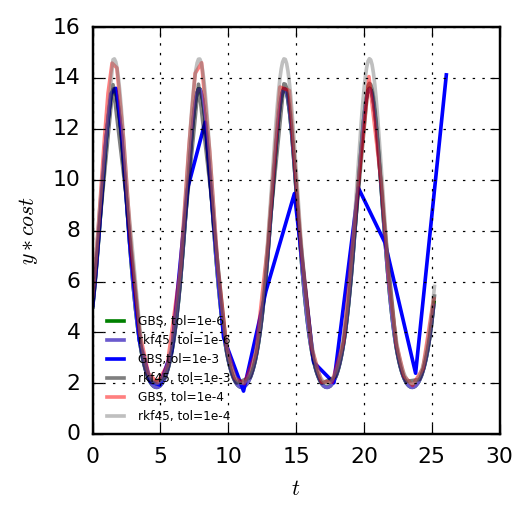

In [314]:
plot_pretty()
#plt.xscale('log'); plt.yscale('log')
plt.figure(figsize=(3,3))

plt.plot(i1[0], i1[1], lw=1.5, c='green', alpha=1., label='GBS, tol=1e-6')
plt.plot(i2[0], i2[1], lw=1.5, c='slateblue', alpha=1., label='rkf45, tol=1e-6')

plt.plot(i3[0], i3[1], lw=1.5, c='blue', alpha=1., label='GBS,tol=1e-3')
plt.plot(i4[0], i4[1], lw=1.5, c='black', alpha=0.5, label='rkf45, tol=1e-3')

plt.plot(i5[0], i5[1], lw=1.5, c='red', alpha=0.5, label='GBS, tol=1e-4')
plt.plot(i6[0], i6[1], lw=1.5, c='grey', alpha=0.5, label='rkf45, tol=1e-4')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.xlabel('$t$'); plt.ylabel('$y*cost$')
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

In [ ]:
#Notes: rkf45 is faster and reaches desired accuracy quicker (for smaller tolerance). 



b. (10 points) Integrate orbit of a particle located at the radius $1\ \rm AU=1.49598\times 10^{13}$ cm  from a stationary point mass of $1\ M_{\odot}=1.9891\times 10^{33}$ g (integrate only 1 particle in the analytic potential, not the 2-body problem) using analytical force from the point mass $\vec{a}=-GM\vec{r}/r^3$, where $\vec{r}$ is the vector from the central gravitating mass to the point. 

Before you integrate choose reasonable <i>units</i> for numerical integration for mass, $M_0$, radius, $r_0$, and time, $t_0$. Convert physical equations into dimensionless numerical equations by normalizing all quantities using these units: i.e., $\tilde{t}=t/t_0$, $\tilde{M}=M/M_0$, $\tilde{v}=v/(r_0/t_0)$, etc. (don't forget to convert derivatives in the equations of motion as well!) The choice of units is up to you. I will just give two guidelines: 1) units should be "natural" for the values of the corresponding variables in the problem; this will result in variable values that are not too large or not too small but are within the natural range of values for this problem; 2) everything should be self-consistent (if $t_0$ and $r_0$ are units of time and distance, then unit of velocity should be $r_0/t_0$). Choosing units so that $G=1$ is a popular choice (the corresponding units for other variables then will need to be figured out), but it does not have to be unity, just <i>of order unity.</i>

Set the initial coordinates at $x=\tilde{r}$, $y=z=0$ (in the system where the star is at $(0,0,0))$ and set the $y$ component of the initial velocity corresponding to the circular orbit and other components to zero. 

1) Perform the integration using explicit forward Euler scheme and the 4th order Runge-Kutta method with constant step size (you can use my routines from ex03.ipynb). Choose the step size to be $0.01$ of the orbital period of the particle, $\tilde{P}=2\pi \tilde{r}/\tilde{v}_{\rm circ}$, where ${\rm v}_{\rm circ}$ is velocity of the particle corresponding to circular orbit (i.e., 100 steps per orbital period). 
Integrate the  particle for $\approx 100$ orbits. Examine secular evolution of the radius of the orbit (i.e., distance to $(0,0,0)$) and total energy of the particle (i.e., the sum of kinetic and potential energies: $E=-GM/r^2 + v^2/2$, where $v=[v_x^2+v_y^2+v_z^2]^{1/2}$). What do you see? Try repeating integrations with smaller time steps. How do results change? 



In [35]:

# 1st order Runge-Kutta method (forward Euler) with constant step



def euler_rk1_eom(f,r_init,t_init,t_end,dt,v_init, **kwargs):
    r,t,v = np.copy(r_init), (t_init), np.copy(v_init);
    #kwargs = velocity_init
    
    
    tout = [t]; rout=[(r[0],r[1],r[2])]; vout = [(v[0],v[1],v[2])];
    
    while t < t_end:
        r_old = np.copy(r)
        v_old = np.copy(v)
        
        v += dt*f(t,r_old,**kwargs)
        r += v_old*dt
        
        t += dt
        
        tout.append(t); rout.append((r[0],r[1],r[2])); vout.append((v[0],v[1],v[2]))
    return tout, rout, vout

#########################################
#
# 4th order Runge-Kutta method with constant step
#

def rk4_eom(f, r_init, t_init, t_end, dt, v_init, **kwargs):
    
    r,t,v = np.copy(r_init), (t_init), np.copy(v_init);
    tout = [t]; rout=[(r[0],r[1],r[2])]; vout = [(v[0],v[1],v[2])];
    
    while t < t_end:
        
        r_old = np.copy(r)
        v_old = np.copy(v)
        
        kr1 = v_old; kv1 = f(t, r, **kwargs);
        kr2 = v_old + kv1*dt/2; kv2 = f(t + 0.5*dt, r_old + 0.5*dt*kr1, **kwargs);
        kr3 = v_old + kv2*dt/2; kv3 = f(t + 0.5*dt, r_old + 0.5*dt*kr2, **kwargs);
        kr4 = v_old + kv3*dt;  kv4 = f(t + dt,     r_old + dt*kr3,     **kwargs);
        
        #kv1 = f(t, r, **kwargs); kr1 = v; 
        #kv2 = f(t + 0.5*dt, r + 0.5*dt*kr1, **kwargs); kr2 = v + kv1*dt/2
        #kv3 = f(t + 0.5*dt, r + 0.5*dt*kr2, **kwargs); kr3 = v + kv2*dt/2
        #kv4 = f(t + dt,     r + dt*kr3,     **kwargs); kr4 = v + kv3*dt
        
        v += (dt/6.0)*(kv1 + 2.0*kv2 + 2.0*kv3 + kv4)
        r += (dt/6.0)*(kr1 + 2.0*kr2 + 2.0*kr3 + kr4)
        
        
        t += dt
        tout.append(t); rout.append((r[0],r[1],r[2])); vout.append((v[0],v[1],v[2]))
        #tout = np.vstack((tout,t)); yout = np.vstack((yout,y))
    return tout, rout, vout 

# Can also solve systems of linear equations : keep in mind that

In [318]:
r_0 = 1.49598e+13 #1 AU
G = 6.6743e-8; G0 = 10**-8  #cgs units - cm**3 g**-1 s**-2

r = 1.49598e+13 ; #r0 = 10**13 #centimetres
mass = 1.9891e+33; #M0 = 10**33 #grams



v_init = np.sqrt(G*mass/r); # cm/s
print v_init

P = 2*np.pi*r/v_init
t = 0; 
t0 = 3.154e+7 #Number of seconds in a year


#Natural Units
G = G/(r**3 * mass**-1 * P**-2)
mass /= mass

#Initial conditions
r_vec = np.array([r,0,0])

velocity = np.zeros(3)
vx = 0; vy = v_init; vz = 0 #km/s
velocity[0] = vx 
velocity[1] = vy
velocity[2] = vz

velocity /= (r/P)
r_vec /= r

print velocity
print r_vec
print mass
print G
#Since there is no initial z-velocity, the radial force ensures that the object stays in one plane: x-y plane

def func_acceler(t, r, **kwargs):
    mass = 1
    r_mod = np.linalg.norm(r)
    return -G*mass*r/(r_mod**3)

steps_list = [10,100,10000]
hlist = 1/np.array(steps_list)

print hlist

#time, radius, vel =  euler_rk1_eom(func_acceler, r_vec,t,100*P,h,velocity)
#radius = np.asarray(radius)
#vel = np.asarray(vel)

def energy_tot(mass,r,v):
    mass = 1
    r_mod = np.linalg.norm(r,axis=1)
    v_mod = np.linalg.norm(v,axis=1)
    return (G*mass/r_mod) + 0.5*(v_mod**2)

2978984.72829
[ 0.          6.28318531  0.        ]
[ 1.  0.  0.]
1.0
39.4784176044
[ 0.1     0.01    0.0001]


In [319]:
#print radius

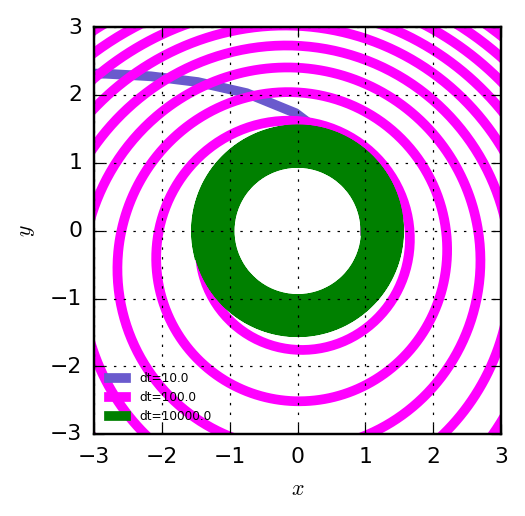

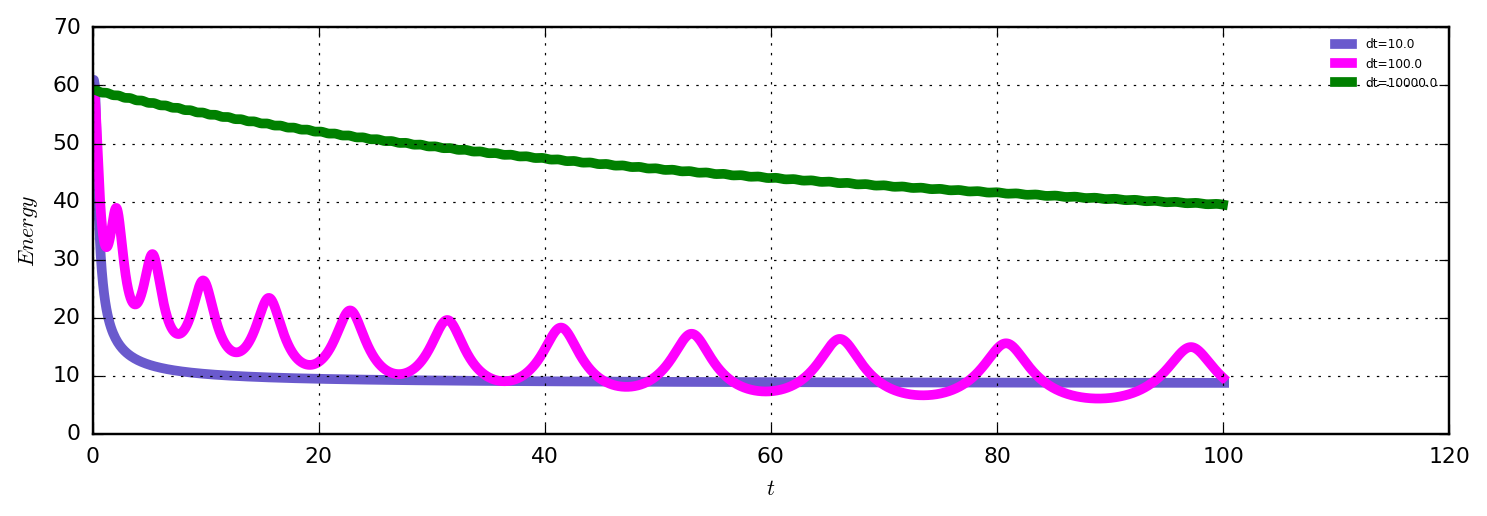

In [321]:


plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))

#hlist = [P*0.01, P*0.001, P*0.0001]
c = ['slateblue', 'magenta','green']

t=0

for i, h in enumerate(hlist):
    time, radius, vel =  euler_rk1_eom(func_acceler, r_vec,t,100,h,velocity)
    radius = np.asarray(radius)
    vel = np.asarray(vel)
#plt.plot(time, radius[:,0], lw=4.0, c='darkslateblue', alpha=1., label='rk1')
    plt.plot(radius[:,0], radius[:,1], lw=4.0, c=c[i], alpha=1., label='dt=%.1f'%steps_list[i])
    plt.xlim(-3,3); plt.ylim(-3,3)
   
#plt.tight_layout()
plt.grid()
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

#Energy plots

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(10,3))

#hlist = [P*0.01, P*0.001, P*0.0001]
c = ['slateblue', 'magenta','green']

for i, h in enumerate(hlist):
    time, radius, vel =  euler_rk1_eom(func_acceler, r_vec,t,100,h,velocity)
    radius = np.asarray(radius)
    vel = np.asarray(vel)
    energy = np.asarray(energy_tot(mass,radius,vel))
#plt.plot(time, radius[:,0], lw=4.0, c='darkslateblue', alpha=1., label='rk1')
    plt.plot(time, energy, lw=4.0, c=c[i], alpha=1., label='dt=%.1f'%steps_list[i])
  
#plt.tight_layout()
plt.xlabel('$t$'); plt.ylabel('$Energy$')
plt.grid()
plt.legend(frameon=False, loc='upper right', fontsize=5)   
plt.show()

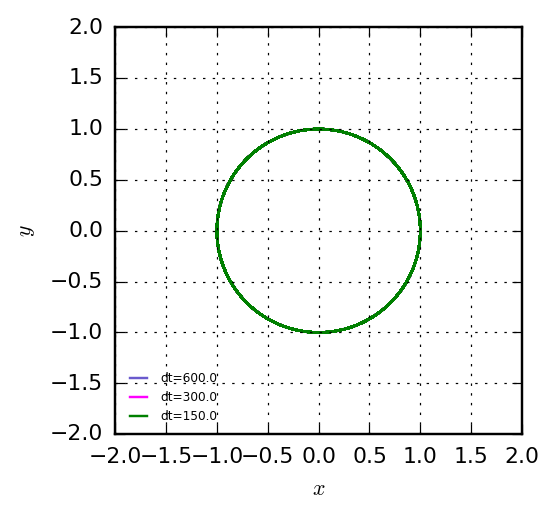

In [322]:
#RK4

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))

steps_list = [600,300,150]
hlist = 1/np.asarray(steps_list)
#hlist = [P*0.01, P*0.001, P*0.0001]
c = ['slateblue', 'magenta','green']

for i, h in enumerate(hlist):
    time2, radius2, vel2 =  rk4_eom(func_acceler, r_vec,t,100,h,velocity)
    radius2 = np.asarray(radius2)
    vel2 = np.asarray(vel2)
#plt.plot(time, radius[:,0], lw=4.0, c='darkslateblue', alpha=1., label='rk1')
    plt.plot(radius2[:,0], radius2[:,1], lw=1.0, c=c[i], alpha=1., label='dt=%.1f'%steps_list[i])
    plt.xlim(-2,2); plt.ylim(-2,2)
   
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()




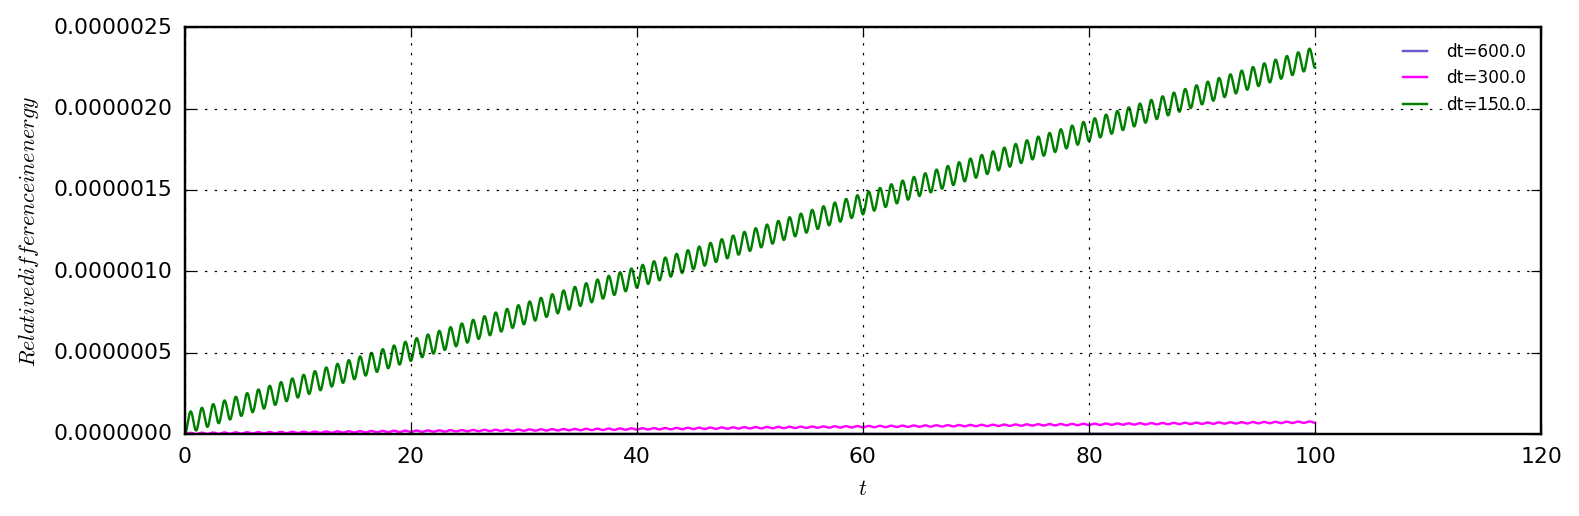

In [323]:
#Energy plots

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(10,3))

#hlist = [P*0.01, P*0.001, P*0.0001]


for i, h in enumerate(hlist):
    time2, radius2, vel2 =  rk4_eom(func_acceler, r_vec,t,100,h,velocity)  
    energy2 = np.asarray(energy_tot(mass,radius2,vel2))
#plt.plot(time, radius[:,0], lw=4.0, c='darkslateblue', alpha=1., label='rk1')
    plt.plot(time2, (energy2 - energy2[0])/energy2[0], lw=1.0, c=c[i], alpha=1., label='dt=%.1f'%steps_list[i])
   
#plt.tight_layout()
plt.grid()
plt.xlabel('$t$'); plt.ylabel('$Relative difference in energy$')
plt.legend(frameon=False, loc='upper right', fontsize=7)   
plt.show()


2) Repeat the integration with your GBS routine developed in 1a with adaptive step size. Compare results to the experiments with constant step above and comment on and try to explain any differences that you see. (if you did not get your GBS routine working, use my rkf45 routine from <a href="https://github.com/a-kravtsov/a330f16/blob/master/ex03.ipynb">ex03.ipynb</a> or scipy's ODE integration routine <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html"><tt>odeint</tt></a> for this part.)

[[ 1.          0.          0.        ]
 [ 0.          6.28318531  0.        ]]
31552761.807
315527.61807
39.4784176044


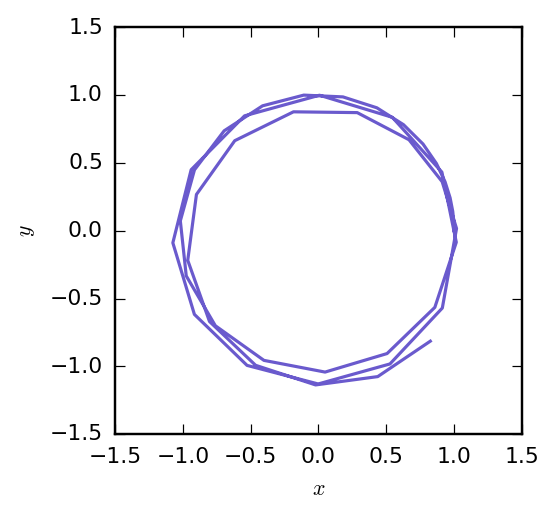

In [328]:
def func_acceler_gbs(t, r):
    #mass = 1.9891e+33
    mass = 1
    x = r[0]
    v = r[1]
    r_mod = np.linalg.norm(x)
    return np.vstack([v,-G*mass*x/(r_mod**3)])

r0 = np.vstack([r_vec,velocity])
#gbs_adaptive_general(func_acceler_gbs, r0, t_start, t_end, H, epsilon):

#for i, h in enumerate(hlist):
print r0
print P
print 0.01*P
print G
time3, r3, steps3 =  gbs_adaptive_general(func_acceler_gbs,r0,t_start=0,t_end=3,H=0.01,epsilon=1e-5)


time3 = np.asarray(time3)
r3 = np.asarray(r3)
steps3 = np.asarray(steps3)
#print r3.shape
#radius3 = np.asarray(r3[:,0,0])
#vel3 = np.asarray(r3[:,0,1])
#plt.plot(time, radius[:,0], lw=4.0, c='darkslateblue', alpha=1., label='rk1')
plt.figure(figsize=(3,3))
plt.plot(r3[:,0,0], r3[:,0,1], lw=1.3, c='slateblue', alpha=1., label='dt')
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.xlabel('$x$'); plt.ylabel('$y$')


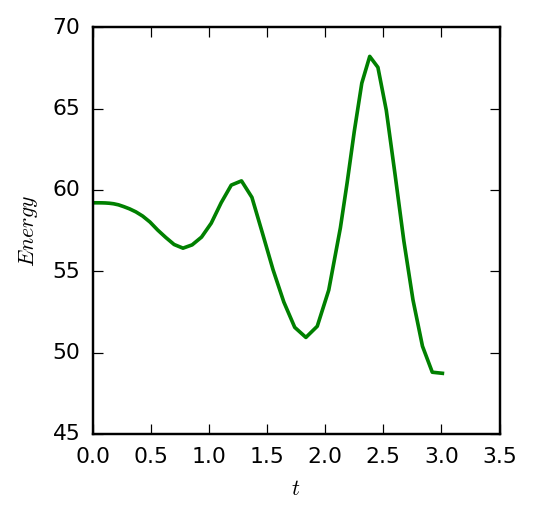

In [329]:
energy = np.asarray(energy_tot(1,r3[:,0],r3[:,1]))
plt.figure(figsize=(3,3))
plt.plot(time3, energy, lw=1.5, c='green', alpha=1., label='dt')
plt.xlabel('$t$'); plt.ylabel('$Energy$')

<b>3. (30 points) <i>Ionization history of the universe</i>.</b> 

The table is splined for use in the ODE describing evolution of ionized hydrogen abundance:
$$\dot{n}_{\rm HI} = 3H(a)n_{\rm HI} - n_{\rm HI}\Gamma_{\rm HI} + R(T)n_{\rm e} n_{\rm HII}, $$
where $\dot{n}_{\rm HI}$ is number density of neutral hydrogen, $H(a)$ is the Hubble "constant" at the expansion factor $a\equiv 1/(1+z)$, where $z$ is redshift, $\Gamma_{\rm HI}$ is the rate of HI ionizing photons in the Universe at redshift $z$, $R(T)$ is the recombination rate of protons and electrons and $n_{\rm e}$, $n_{\rm HII}$ are the number density of electrons and protons, respectively. 

Let's assume that intergalactic medium consists only of hydrogen (i.e., we are neglecting helium). Then the above  equation is more convenient to write in terms of dimensionless neutral fraction of hydrogen $x_{\rm HI}\equiv n_{\rm HI}/(n_{\rm e}+n_{\rm HII})$:
$$\dot{x}_{\rm HI} =  - x_{\rm HI}\Gamma_{\rm HI} + R(T)n_{\rm H}(1-x_{\rm HI})^2, $$
where $n_{\rm H}$ is hydrogen number density, which is approximately $n_{\rm H}=0.9\bar{n}_{\rm b}(1+\delta)$, $\bar{n}_{\rm b}=2.5\times 10^{-7}a^{-3}\ \rm cm^{-3}$ is the mean density of baryons in the universe and $\delta$ is overdensity. The $3H(a)$ term accounts for cosmic expansion. You can use 
colossus routine <a href="http://bdiemer.bitbucket.org/cosmology_cosmology.html#cosmology.cosmology.Cosmology.Hz">Hz</a>  to compute it.

The above equation involves temperature and so we need a second equation for plasma temperature:
$$\dot{T}=\frac{2T}{3}\frac{\dot{n}_H}{n_{\rm H}} + x_{\rm HI}\Gamma_{\rm HI} H_{\rm HI},$$
where the second term above describes adiabatic cooling due to expansion of the universe and $H_{\rm HI}$ is the increment of temperature each ionization incurs  (this corresponds to the average energy of electron kicked out by ionization even divided by Boltzmann constant). $R(t)$ can be approximated as
$$R(t)=4.3\times 10^{-13} \frac{T_4^{-0.7}}{1+(T_4/10^4)^4}\ \rm cm^3/s,$$
where $T_4=T/10^4\ \rm K$. 

With this information in hand, the task is to compute ionization and thermal history of hydrogen: $x_{\rm HI}(t)$ and $T(t)$. The rates $\Gamma_{\rm HI}$ and $H_{\rm HI}$ energy per ionization are read in and splined for use below. The code snippet below reads in the neutral hydrogen ionizing photon rate and heating rate in photons and $\Delta$ Kelvin per second, computed by Piero Madau and Francesco Haardt, using their model for evolving ionizing radiation sources (galaxies+quasars). The <a href="http://www.ucolick.org/~pmadau/CUBA/Media/photorates.out">table</a> was downloaded from Piero Madau's <a href="http://www.ucolick.org/~pmadau/CUBA/HOME.html">CUBA radiative transfer code</a> page. 


In [73]:
# read in ionization and heating rates
import numpy as np
from codes.setup import data_home_dir
from scipy.interpolate import UnivariateSpline

fname = data_home_dir()+'photorates.dat'

# read in redshift and ionization [1/s] and heating rates [eV/s] of hydrogen
z, G_HI, H_HI = np.loadtxt(fname, usecols=(0,1,2), unpack=True)
#print z
print G_HI

# convert eV/s to K/s
H_HI = H_HI/G_HI * 1.1604e4 # <- = eV/k

from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}

# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
cosmo.interpolation = False
tU = cosmo.age(z) # age of the universe as a function of z in Gyrs for the above cosmology
# Hubble "constant" at z in km/s/Mpc -> really its unit is 1/time
# you need to convert H(a) to the time units you will be using in your calculation  
Hz = cosmo.Hz(z)

print z
print Hz
print tU #numpy array

print "z = %.3f, t_age(z)=%.3f Gyrs, H(z)=%.3e km/s/Mpc"%(z[10], tU[10], Hz[10])
# spline the tabulated values, inverting the order to make time monotonically increasing
# as required by UnivariateSpline
GHIs = UnivariateSpline(tU[::-1], G_HI[::-1], s=0.0)
HHIs = UnivariateSpline(tU[::-1], H_HI[::-1], s=0.0)
Hzs = UnivariateSpline(tU[::-1], Hz[::-1], s=0.0)
zs = UnivariateSpline(tU[::-1], z[::-1], s=0.0)
#tU = tU[::-1]
#print tU

[  2.28000000e-14   2.84000000e-14   3.54000000e-14   4.40000000e-14
   5.46000000e-14   6.74000000e-14   8.31000000e-14   1.02000000e-13
   1.25000000e-13   1.52000000e-13   1.85000000e-13   2.23000000e-13
   2.67000000e-13   3.18000000e-13   3.76000000e-13   4.40000000e-13
   5.10000000e-13   5.85000000e-13   6.60000000e-13   7.32000000e-13
   7.99000000e-13   8.59000000e-13   9.09000000e-13   9.44000000e-13
   9.63000000e-13   9.65000000e-13   9.50000000e-13   9.19000000e-13
   8.75000000e-13   8.22000000e-13   7.65000000e-13   7.05000000e-13
   6.47000000e-13   5.94000000e-13   5.46000000e-13   5.04000000e-13
   4.69000000e-13   4.41000000e-13   4.12000000e-13   3.60000000e-13
   2.93000000e-13   2.30000000e-13   1.75000000e-13   1.29000000e-13
   9.28000000e-14   6.55000000e-14   4.56000000e-14   3.12000000e-14
   2.12000000e-14   1.43000000e-14   9.59000000e-15   6.40000000e-15
   4.27000000e-15   2.92000000e-15   1.73000000e-15   1.02000000e-15
   5.92000000e-16   3.41000000e-16

In [59]:
t = 2.5e9
print "at t_U = %.3e yrs"%t
print "Ionization rate = %.3e 1/s, dT (in K) per ionization = %.3f"%(GHIs(t/1.e9), HHIs(t/1.e9)) #Input is t (gigayears)

at t_U = 2.500e+09 yrs
Ionization rate = 9.095e-13 1/s, dT (in K) per ionization = 45850.298


[  2.28000000e-14   2.84000000e-14   3.54000000e-14   4.40000000e-14
   5.46000000e-14   6.74000000e-14   8.31000000e-14   1.02000000e-13
   1.25000000e-13   1.52000000e-13   1.85000000e-13   2.23000000e-13
   2.67000000e-13   3.18000000e-13   3.76000000e-13   4.40000000e-13
   5.10000000e-13   5.85000000e-13   6.60000000e-13   7.32000000e-13
   7.99000000e-13   8.59000000e-13   9.09000000e-13   9.44000000e-13
   9.63000000e-13   9.65000000e-13   9.50000000e-13   9.19000000e-13
   8.75000000e-13   8.22000000e-13   7.65000000e-13   7.05000000e-13
   6.47000000e-13   5.94000000e-13   5.46000000e-13   5.04000000e-13
   4.69000000e-13   4.41000000e-13   4.12000000e-13   3.60000000e-13
   2.93000000e-13   2.30000000e-13   1.75000000e-13   1.29000000e-13
   9.28000000e-14   6.55000000e-14   4.56000000e-14   3.12000000e-14
   2.12000000e-14   1.43000000e-14   9.59000000e-15   6.40000000e-15
   4.27000000e-15   2.92000000e-15   1.73000000e-15   1.02000000e-15
   5.92000000e-16   3.41000000e-16

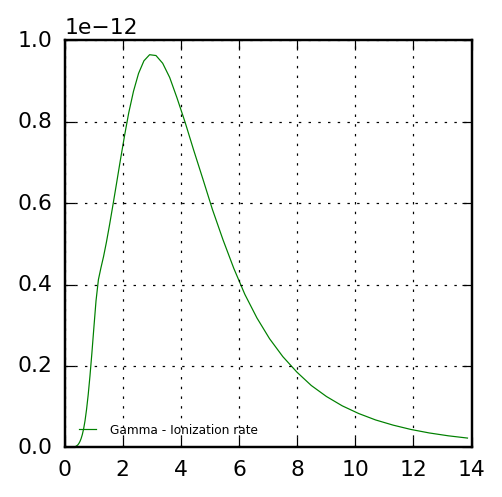

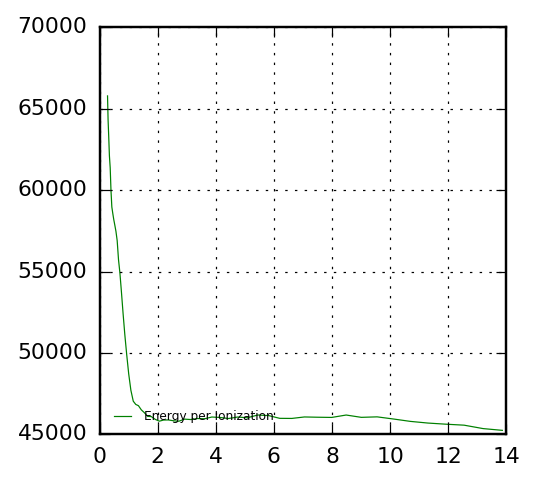

In [67]:
print GHIs(tU)
print HHIs.derivative()(tU)

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.plot(tU, GHIs(tU), lw=0.5, c='green', alpha=1., label='Gamma - Ionization rate')
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))
plt.xlabel('$t$'); plt.ylabel('$y$')
plt.plot(tU, HHIs(tU), lw=0.5, c='green', alpha=1., label='Energy per Ionization')
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

^ Gamma and H(Kelvin) as a function of T(gigayears)

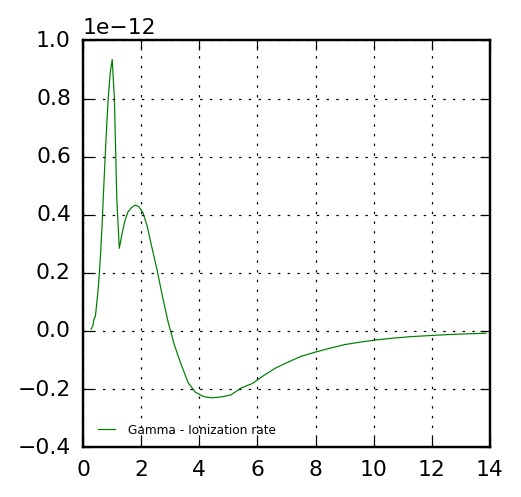

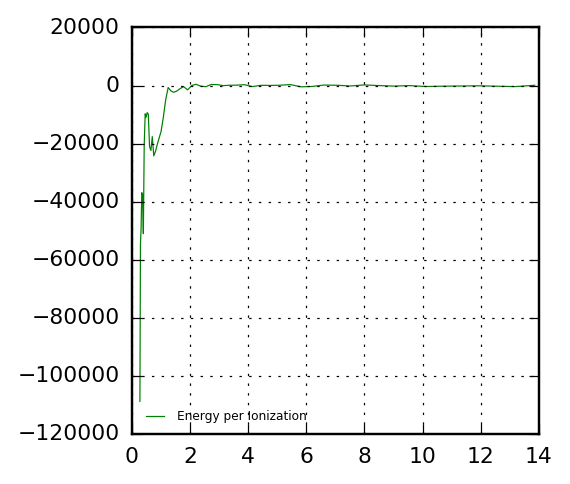

In [68]:
#Rate of change of the two quantities

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))
plt.plot(tU, GHIs.derivative()(tU), lw=0.5, c='green', alpha=1., label='Gamma - Ionization rate')
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
#plt.xlim(t0+1.e-6,tf); plt.ylim(y0+1.e-6,3.)
plt.figure(figsize=(3,3))
plt.plot(tU, HHIs.derivative()(tU), lw=0.5, c='green', alpha=1., label='Energy per Ionization')
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

Particularly address the following questions:

a. (5 points) Think about equations above. What are the relevant time scales in the problem? What are the reasonable units for the numerical integration of these equations? Present your thoughts and arguments.


The equations, on simplification (non-normalized) reduce to:

(1) $$\dot{x}_{\rm HI} =  - x_{\rm HI}\Gamma_{\rm HI} + R(T)n_{\rm H}(1 - x_{\rm HII})^2$$

(2) $$\dot{T}=-2H(a)T + x_{\rm HI}\Gamma_{\rm HI} H_{\rm HI},$$


If units are kept as follows :

t = seconds, volume = cm^3

For (1): Term 1 is of the order 1e-13, while term 2 is of the order 1e-17. If the change in x is order unity, that leads to a timescale change in x of a few hundred million years, approximately.
For (2): Term 1 is of the order 1e-13, while term 2 is of the order 1e-9. If the change in T is order 1e4, that leads to a timescale change in temperature of around a gigayear, approximately.

Reasonable units: t = in gigayears, T = in 1e4 K units




In [336]:
def n(k):
    return 2*(k+1)
    


def gbs_adaptive_ion(f, r0, t_start, t_end, H, epsilon,argum):    
    t, r, H_init = t_start, r0, H; 
    tout = [t]; rout = [np.copy(r)]; steps=[H]    
    e = epsilon
    Hmin = H*(5e-4)
    Hmax = 100*H  
    while t < t_end:
            t_i = t
            r_i = r          
            def G_lm(l,m):         
                if m == 0:
                    h = H_init/(2*(l+1)) 
                    s_timesteps = np.arange(t_i,t_i+H_init,h)         
                    for s,ts in enumerate(s_timesteps):                     
                        if s == 0:  #Step 1 : Calculate y(s=0) and y(s=1) using RK1
                            rs = r_i
                            rs_old = rs
                        if s == 1:
                            rs = r_i + 2*h*f(t_i,r_i,argum)
                        else:
                            rs_new = rs_old + 2*h*f(ts,rs,argum)
                            rs_old = rs
                            rs = rs_new
                    return rs   
                else:
                    term1 = (n(l)**2)*G_lm(l,m-1)
                    term2 =(n(l-m)**2)*G_lm(l-1,m-1)
                    return (term1 - term2)/((n(l)**2) - (n(l-m)**2))   
        
            m = 8 #According to question  #Change to m=5 later
            
            r_m = G_lm(m+1,m)
            r_mplus1 = G_lm(m+1,m+1)       
            #Implementing Adaptive time step control
            errorterm = np.abs(r_m[0] - r_mplus1[0]).max()        
            #Fudge factor w is ignored
            delta = (e/errorterm)**(1/(2*m+2))
            
            print 'For time = ', t
            print 'Calculated x is', r_m[0] #testing
            print 'Calculated T is', r_m[1]
            print 'Calculated Step size is', H_init
            print
            
            #Applying non-negativity constraint + adaptive time step control 
            
            if (errorterm < epsilon).any() and (r_m >= 0).all() and (r_m[0] <= 1).all(): 
                r = r_m
                t = t + H_init
                if (delta>=1.0).any():
                    H_init = np.minimum(H_init*delta,Hmax)
                else:
                    H_init = np.minimum(H_init/deta,Hmax)
                tout.append(t)
                rout.append(r)
                steps.append(H_init)      
            else:    #All the bad cases
                if (delta >= 1.0).any():
                    H_init /= delta
                else:
                    H_init *= delta    
                if (H_init < Hmin).any():
                    print H_init
                    raise Exception("step size H less than Hmin!")          
           
                
               
    return np.asarray(tout), np.asarray(rout)#, np.asarray(steps)



b. (10 points) Try to integrate these equations starting at $z=8$ and to $z=0$ for plasma at the mean density of the universe $\delta=0$ with the GBS solver you developed in 1. (If you did not manage to get it working use my RKF45 solver from <a href="">ex03.ipynb</a>). Do you encounter any difficulties? If so what kind of difficulties? Try to think creatively and figure out how to get around them and get the final results of this task: a plot of $x_{\rm HI}$ and $T$ as a function of cosmic time. 





In [ ]:
nH = lambda t: (0.9*2.5e-7)*(1/(1+zs(t)))**-3
t = np.linspace(2,8,100)
#plt.plot(t,nH(t))

s_2_gig = 3.17098e-17
km_2_Mpc = 3.24078e-20


#UNITS: t = Gigayears, Temperature = 10^4 K

def func_system(t,w,argum):
    xH1 = np.asarray(w[0]); T = np.asarray(w[1])
    Hzs = argum[0]; GHIs = argum[1]; HHIs = argum[2]; nH = argum[3]
    Rt = 4.3e-13*((T)**-0.7)/(1 +(T/(10**4))**4) 
    
    term1_1=0
    term1_2=0
    term2_1=0
    term2_2=0
    
    term1_1 = - xH1*(GHIs(t)/s_2_gig)
    term1_2 = Rt*nH(t)*((1-xH1)**2)
    
    term2_1 = -2*(Hzs(t)/(s_2_gig/km_2_Mpc))*T
    term2_2 = xH1*(GHIs(t)/s_2_gig)*(HHIs(t)/1e4)
    
    f = np.vstack([ term1_1 + term1_2, term2_1 + term2_2  ])
    return f

#Figure out a way to print stuff about this 




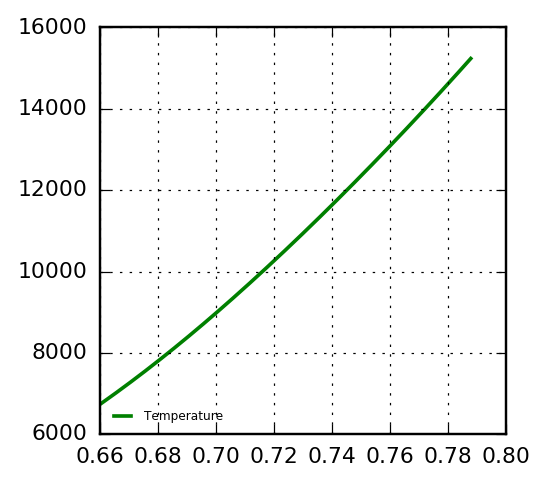

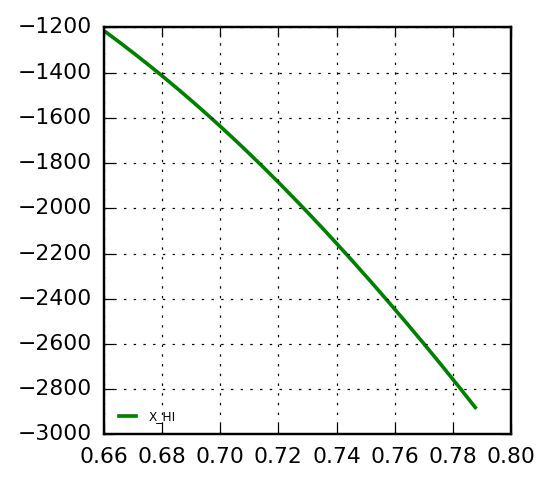

In [278]:
T0 = [10]
xH10 = [0.8]
    
w_init = [xH10,T0]
argum_init = [Hzs, GHIs,HHIs,nH]   #Define gbs such that there's a place for argum_init : DONE


H = 0.0001 #in gigayears
t_start = cosmo.age(8)
t_end = cosmo.age(7)
t = np.arange(t_start,t_end,H)

func_eg = func_system(t,w_init,argum_init)

#Testing rate equations

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
plt.figure(figsize=(3,3))
plt.plot(t, func_eg[1,:], lw=1.5, c='green', alpha=1., label='Temperature')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

plot_pretty()
#plt.xscale('log'); plt.yscale('log')
plt.figure(figsize=(3,3))
plt.plot(t, func_eg[0,:], lw=1.5, c='green', alpha=1., label='X_HI')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()


In [282]:
tstart = clock()
#gbs_adaptive_general(f, r0, t_start, t_end, H, epsilon)
t_out,ion_temp_vec = gbs_adaptive_ion(func_system, w_init, t_start, t_end, H, epsilon=0.0001,argum=argum_init)

print 'gbs for reionization rates runs for', clock() - tstart

For time =  0.660730245239
Calculated x is [ 0.21418766]
Calculated T is [ 13.23029378]
Calculated Step size is 0.001

For time =  0.661730245239
Calculated x is [ 0.03240301]
Calculated T is [ 14.21183173]
Calculated Step size is 0.00101960129391

For time =  0.662749846533
Calculated x is [ 0.00807871]
Calculated T is [ 14.31494746]
Calculated Step size is 0.00111393669848

For time =  0.663863783231
Calculated x is [ -3.84217427e-05]
Calculated T is [ 14.32181811]
Calculated Step size is 0.00133160135793

For time =  0.663863783231
Calculated x is [ 0.00098874]
Calculated T is [ 14.32377961]
Calculated Step size is 0.00106407364301

For time =  0.664927856874
Calculated x is [ -3.59291108e-05]
Calculated T is [ 14.28993239]
Calculated Step size is 0.0013820786057

For time =  0.664927856874
Calculated x is [ 0.00015151]
Calculated T is [ 14.3000665]
Calculated Step size is 0.000990792348713

For time =  0.665918649223
Calculated x is [  4.23303835e-05]
Calculated T is [ 14.25905029]

In [ ]:
print '', ion_temp_vec[:,1]



There are several reasons why this part's code is not working. 

1. I implemented a non-negative truncation switch to gbs i.e. if x and T go out of the range 0 <= x <=1 and T =< 0, then reduce H and perform another calculation. 
2. Even after reduction of timesteps by several orders of magnitude, I am not getting a physically meaningful result for this extremely stiff equation around the initial conditions.

Initial conditions are extremely important for the very first step size. Moreover, the non-negative condition is crucial too.

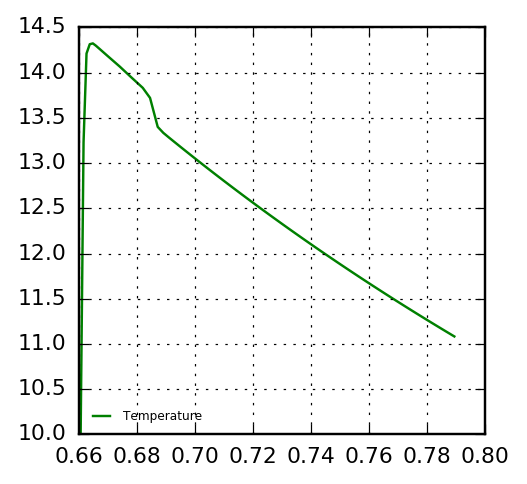

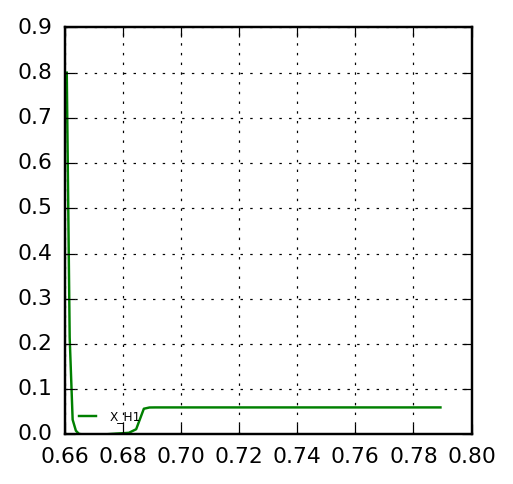

In [285]:
#Plotting Temperature evolution

plot_pretty()
#plt.xscale('log'); plt.yscale('log')

plt.figure(figsize=(3,3))
plt.plot(t_out, ion_temp_vec[:,1], lw=1, c='green', alpha=1., label='Temperature')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

plt.figure(figsize=(3,3))
plt.plot(t_out, ion_temp_vec[:,0], lw=1, c='green', alpha=1., label='X_H1')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

c. (5 points) Suppose at $z=2$ a quasar turned on right next to the region for which you are computing evolution, so that $\Gamma_{\rm HI}$ increased instantaneously to $10^{-10}\ s^{-1}$ and $H_{\rm HI}$ increased by a factor of 2 and these rates were constant for $10^7$ years - a typical quasar lifetime. Can you integrate through such an event? What is the effect of this event on $x_{\rm HI}$ and $T$ for the interval you can integrate?



In [ ]:
H=0.01
t_start = cosmo.age(8)
t_end = cosmo.age(2)
#t = np.arange(t_start,t_end,H)
T0 = [5]
xH10 = [0.6]
w_init = [xH10,T0]
argum_init = [Hzs, GHIs,HHIs,nH]

#gbs_adaptive_general(f, r0, t_start, t_end, H, epsilon)
#Step1
t_out,ion_temp_vec = gbs_adaptive_ion(func_system, w_init, t_start, t_end, H, epsilon=0.0001,argum=argum_init)




In [ ]:
#Step 2Quasar switches on
T_init_quasar = ion_temp_vec[-1,1]
x_init_quasar = ion_temp_vec[-1,0]

def func_system_Quasar(t,w,argum):
    xH1 = np.asarray(w[0]); T = np.asarray(w[1])
    Hzs = argum[0]; GHIs = 1e-10; HHIs = 2*argum[2]; nH = argum[3]   #Just added the new quasar parameters
    Rt = 4.3e-13*((T)**-0.7)/(1 +(T/(10**4))**4) 
    
    term1_1=0
    term1_2=0
    term2_1=0
    term2_2=0
    
    term1_1 = - xH1*(GHIs(t)/s_2_gig)
    term1_2 = Rt*nH(t)*((1-xH1)**2)
    term2_1 = -2*(Hzs(t)/(s_2_gig/km_2_Mpc))*T
    term2_2 = xH1*(GHIs(t)/s_2_gig)*(HHIs(t)/1e4)
    
    f = np.vstack([ term1_1 + term1_2, term2_1 + term2_2  ])
    return f

w_init_quasar = [x_init_quasar,T_init_quasar]
argum_init_quasar = [Hzs, GHIs,HHIs,nH]

t_start_quasar = cosmo.age(2)
t_end_quasar = t_start_quasar + 0.01 #gigayears
H = 0.01

t_out2,ion_temp_vec2 = gbs_adaptive_ion(func_system_Quasar, w_init_quasar, t_start_quasar, t_end_quasar, H, epsilon=0.0001,argum=argum_init_quasar)

In [ ]:
#Step 3 : Post quasar
T_init_3 = ion_temp_vec2[-1,1]
x_init_3 = ion_temp_vec2[-1,0]

w_init_3 = [x_init_3,T_init_3]
argum_init_3 = [Hzs, GHIs,HHIs,nH]

t_start_3 = cosmo.age(2)
t_end_3 = cosmo.age(0) #gigayears
H = 0.01

t_out3,ion_temp_vec3 = gbs_adaptive_ion(func_system, w_init_3, t_start_3, t_end_3, H, epsilon=0.0001,argum=argum_init_3)

#1. Integrate using gbs/rkf45 from z=8 to z=2, retrieve Gamma and H_H1 values (we know these at z=2 from the Spline)
#2. Change Gamma and H_H1 by the above factors for t= t(z=2) to t = t(z=2)+ 10**7 years (which is 0.02 giga years) and integrate
#3. Integrate from t = t(z=2)+ 10**7 to t=now, by retrieving Gamma and H_H1 values from previous step

d. (10 points) In the GBS routine you developed, instead of raising Exception when step decreases below minimum value, implement a switch to the 2nd order implicit Crank-Nicolson scheme (S 1.4.2 in the notes) when this happens. Note that because the switch is to a second order scheme, the time step needs to be adjusted as well. Present arguments for how the time step should be adjusted for this scheme. (If you did not manage to get the GBS routine working in 1a, use my rfk45 routine instead for this exercise to implement the implicit scheme and do calculations). Integrate the evolution equations again with this switch in place, adjusting the minimum time step to a value which would make integration
over the age of the universe feasible. Can you integrate to $z=0$ with such implicit switch? Can you integrate through 
the quasar event described in 1c? Present results of the calculation in the form of a plot of $x_{\rm HI}(t)$ and $T(t)$, where $t$ is in Gyrs from the initial time to $t_U\approx 13.6$ Gyrs.

In [313]:
def n(k):
    return 2*(k+1)
    


def gbs_ion_cn(f, r0, t_start, t_end, H, epsilon,argum):    
    t, r, H_init = t_start, r0, H; 
    tout = [t]; rout = [np.copy(r)]; steps=[H]    
    e = epsilon
    Hmin = H*(5e-3)
    Hmax = 100*H  
    while t < t_end:
            t_i = t
            r_i = r          
            def G_lm(l,m):         
                if m == 0:
                    h = H_init/(2*(l+1)) 
                    s_timesteps = np.arange(t_i,t_i+H_init,h)         
                    for s,ts in enumerate(s_timesteps):                     
                        if s == 0:  #Step 1 : Calculate y(s=0) and y(s=1) using RK1
                            rs = r_i
                            rs_old = rs
                        if s == 1:
                            rs = r_i + 2*h*f(t_i,r_i,argum)
                        else:
                            rs_new = rs_old + 2*h*f(ts,rs,argum)
                            rs_old = rs
                            rs = rs_new
                    return rs   
                else:
                    term1 = (n(l)**2)*G_lm(l,m-1)
                    term2 =(n(l-m)**2)*G_lm(l-1,m-1)
                    return (term1 - term2)/((n(l)**2) - (n(l-m)**2))   
        
            m = 5 #According to question  #Change to m=8 later
            
            r_m = G_lm(m+1,m)
            r_mplus1 = G_lm(m+1,m+1)       
            #Implementing Adaptive time step control
            errorterm = np.abs(r_m[0] - r_mplus1[0]).max()        
            #Fudge factor w is ignored
            delta = (e/errorterm)**(1/(2*m+2))
            
            print 'For time = ', t
            print 'Calculated x is', r_m[0] #testing
            print 'Calculated T is', r_m[1]
            print 'Calculated Step size is', H_init
            print
            
            #Applying non-negativity constraint + adaptive time step control 
            
            if (errorterm < epsilon).any() and (r_m >= 0).all() and (r_m[0] <= 1).all(): 
                r = r_m
                t = t + H_init
                if (delta>=1.0).any():
                    H_init = np.minimum(H_init*delta,Hmax)
                else:
                    H_init = np.minimum(H_init/deta,Hmax)
                tout.append(t)
                rout.append(r)
                steps.append(H_init)      
            else:    #All the bad cases
                if (delta >= 1.0).any():
                    H_init /= delta
                else:
                    H_init *= delta    
                if (H_init < Hmin).any():
                    print H_init
                    def taylor_expansion_cn():
                        #See note below this cell
                        
                        return taylor_expansion_cn
                    #raise Exception("step size H less than Hmin!")          
                    r  +=  (H_init/2)*(f(ts,r_m,argum) + f(ts,r_m,argum)*H_init*(taylor_expansion_cn) )
                
               
    return np.asarray(tout), np.asarray(rout)#, np.asarray(steps)


Answer: The Crank-Nicolson scheme is essentially replacing the H_min switch with the following:

y(i+1) = y(i) + h*(f(x,y) + f(x+1,y+1))

I calculate f(x+1,y+1) by taylor expansion --> f(x,,y) + h*(df/dx +df/dy)

I am running out of time here, but implementing this after discussion with other students I was unable to get meaningful results. 

In [312]:
H=0.01
t_start = cosmo.age(8)
t_end = cosmo.age(7.5)
#t = np.arange(t_start,t_end,H)
T0 = [5]
xH10 = [0.6]
w_init = [xH10,T0]
argum_init = [Hzs, GHIs,HHIs,nH]

t_out_cn,ion_temp_vec_cn = gbs_adaptive_ion(func_system, w_init, t_start, t_end, H, epsilon=0.0001,argum=argum_init)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in power


For time =  0.660730245239
Calculated x is [ nan]
Calculated T is [ nan]
Calculated Step size is 0.01



UnboundLocalError: local variable 'rs' referenced before assignment

#An Aside: in both the ODEs there is one term that is several orders of magnitudes larger than the other. Here, I am calculating the solutions to the ODEs by IGNORING LOW MAGNITUDE TERMS, since they contribute negligibly to the rate. Unfortunately, I get different results, but their physical significance is something Iam very uncertain about. 

In [ ]:
def n(k):
    return 2*(k+1)
    


def gbs_adaptive_ion(f, r0, t_start, t_end, H, epsilon,argum):    
    t, r, H_init = t_start, r0, H; 
    tout = [t]; rout = [np.copy(r)]; steps=[H]    
    e = epsilon
    Hmin = H*(5e-3)
    Hmax = 100*H  
    while t < t_end:
            t_i = t
            r_i = r          
            def G_lm(l,m):         
                if m == 0:
                    h = H_init/(2*(l+1)) 
                    s_timesteps = np.arange(t_i,t_i+H_init,h)         
                    for s,ts in enumerate(s_timesteps):                     
                        if s == 0:  #Step 1 : Calculate y(s=0) and y(s=1) using RK1
                            rs = r_i
                            rs_old = rs
                        if s == 1:
                            rs = r_i + 2*h*f(t_i,r_i,argum)
                        else:
                            rs_new = rs_old + 2*h*f(ts,rs,argum)
                            rs_old = rs
                            rs = rs_new
                    return rs   
                else:
                    term1 = (n(l)**2)*G_lm(l,m-1)
                    term2 =(n(l-m)**2)*G_lm(l-1,m-1)
                    return (term1 - term2)/((n(l)**2) - (n(l-m)**2))   
        
            m = 5 #According to question  #Change to m=8 later
            
            r_m = G_lm(m+1,m)
            r_mplus1 = G_lm(m+1,m+1)       
            #Implementing Adaptive time step control
            errorterm = np.abs(r_m[0] - r_mplus1[0]).max()        
            #Fudge factor w is ignored
            delta = (e/errorterm)**(1/(2*m+2))
            
            print 'For time = ', t
            print 'Calculated x is', r_m[0] #testing
            print 'Calculated T is', r_m[1]
            print 'Calculated Step size is', H_init
            print
            
            #Applying non-negativity constraint + adaptive time step control 
            
            if (errorterm < epsilon).any() and (r_m >= 0).all() and (r_m[0] <= 1).all(): 
                r = r_m
                t = t + H_init
                if (delta>=1.0).any():
                    H_init = np.minimum(H_init*delta,Hmax)
                else:
                    H_init = np.minimum(H_init/deta,Hmax)
                tout.append(t)
                rout.append(r)
                steps.append(H_init)      
            else:    #All the bad cases
                if (delta >= 1.0).any():
                    H_init /= delta
                else:
                    H_init *= delta    
                if (H_init < Hmin).any():
                    print H_init
                    raise Exception("step size H less than Hmin!")          
           
                
               
    return np.asarray(tout), np.asarray(rout)#, np.asarray(steps)


In [335]:
def func_system(t,w,argum):
    xH1 = np.asarray(w[0]); T = np.asarray(w[1])
    Hzs = argum[0]; GHIs = argum[1]; HHIs = argum[2]; nH = argum[3]
    Rt = 4.3e-13*((T)**-0.7)/(1 +(T/(10**4))**4) 
    
    term1_1=0
    term1_2=0
    term2_1=0
    term2_2=0
    
    term1_1 = - xH1*(GHIs(t)/s_2_gig)
    #term1_2 = Rt*nH(t)*((1-xH1)**2)
    
    #term2_1 = -2*(Hzs(t)/(s_2_gig/km_2_Mpc))*T
    term2_2 = xH1*(GHIs(t)/s_2_gig)*(HHIs(t)/1e4)
    
    f = np.vstack([ term1_1 + term1_2, term2_1 + term2_2  ])
    return f

T0 = [10]
xH10 = [0.8]
    
w_init = [xH10,T0]
argum_init = [Hzs, GHIs,HHIs,nH]   #Define gbs such that there's a place for argum_init : DONE


H = 0.001 #in gigayears
t_start = cosmo.age(8)
t_end = cosmo.age(7)
t = np.arange(t_start,t_end,H)

from time import time
tstart = time()
#gbs_adaptive_general(f, r0, t_start, t_end, H, epsilon)
t_out,ion_temp_vec = gbs_adaptive_ion(func_system, w_init, t_start, t_end, H, epsilon=0.0001,argum=argum_init)

print 'gbs for reionization rates runs for', time() - tstart

For time =  0.660730245239
Calculated x is [ 0.21418766]
Calculated T is [ 13.25506026]
Calculated Step size is 0.001

For time =  0.661730245239
Calculated x is [ 0.03240301]
Calculated T is [ 14.26479863]
Calculated Step size is 0.00101960129391

For time =  0.662749846533
Calculated x is [ 0.00807871]
Calculated T is [ 14.39986429]
Calculated Step size is 0.00111393669848

For time =  0.663863783231
Calculated x is [ -3.84217427e-05]
Calculated T is [ 14.44491856]
Calculated Step size is 0.00133160135793

For time =  0.663863783231
Calculated x is [ 0.00098874]
Calculated T is [ 14.43921844]
Calculated Step size is 0.00106407364301

For time =  0.664927856874
Calculated x is [ -3.59291108e-05]
Calculated T is [ 14.4449039]
Calculated Step size is 0.0013820786057

For time =  0.664927856874
Calculated x is [ 0.00015151]
Calculated T is [ 14.44386405]
Calculated Step size is 0.000990792348713

For time =  0.665918649223
Calculated x is [  4.23303835e-05]
Calculated T is [ 14.4444697]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in power


For time =  0.682144847573
Calculated x is [-136.68708734]
Calculated T is [ 768.12775435]
Calculated Step size is 0.0059891022348

For time =  0.682144847573
Calculated x is [-1.44120527]
Calculated T is [ 22.39605823]
Calculated Step size is 0.00384339119522

For time =  0.682144847573
Calculated x is [-0.35853267]
Calculated T is [ 16.42310352]
Calculated Step size is 0.00319742187627

For time =  0.682144847573
Calculated x is [ 0.17997996]
Calculated T is [ 13.45142094]
Calculated Step size is 0.00288157423298

For time =  0.682144847573
Calculated x is [ 0.12090406]
Calculated T is [ 13.77740683]
Calculated Step size is 0.00270099931808

For time =  0.682144847573
Calculated x is [ 0.09445904]
Calculated T is [ 13.92333877]
Calculated Step size is 0.00258962580889

For time =  0.682144847573
Calculated x is [ 0.08052447]
Calculated T is [ 14.00023612]
Calculated Step size is 0.00251787372608

For time =  0.682144847573
Calculated x is [ 0.07243521]
Calculated T is [ 14.04487711]


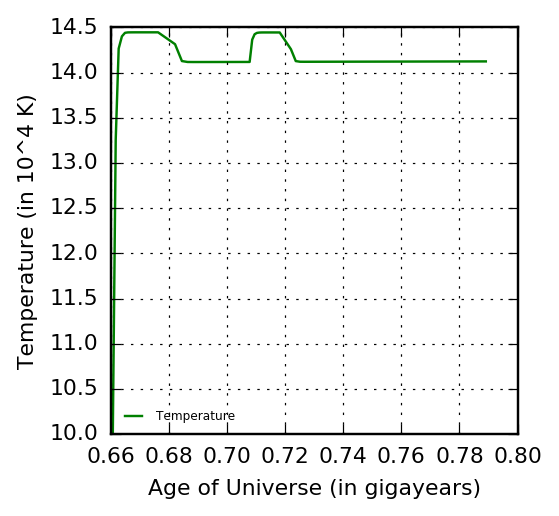

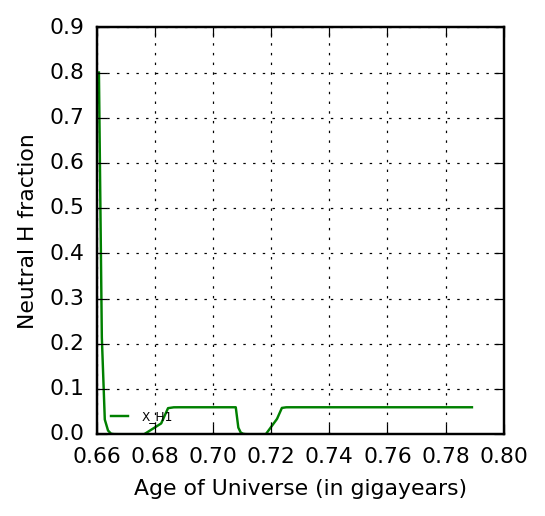

In [337]:
plot_pretty()
#plt.xscale('log'); plt.yscale('log')

plt.figure(figsize=(3,3))
plt.plot(t_out, ion_temp_vec[:,1], lw=1, c='green', alpha=1., label='Temperature')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.xlabel('Age of Universe (in gigayears)'),plt.ylabel('Temperature (in 10^4 K)')
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()

plt.figure(figsize=(3,3))
plt.plot(t_out, ion_temp_vec[:,0], lw=1, c='green', alpha=1., label='X_H1')
#plt.xlim(0.5,0.8); #plt.ylim(y0+1.e-6,3.)
#plt.xlim(-2,2); plt.ylim(-2,2)
plt.grid()
plt.xlabel('Age of Universe (in gigayears)'),plt.ylabel('Neutral H fraction')
plt.legend(frameon=False, loc='lower left', fontsize=5)   
plt.show()